2024-09-10 12:12:42.745330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 12:12:42.766553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 12:12:42.772653: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 19535 images belonging to 2 classes.
Found 4188 images belonging to 2 classes.
Found 4188 images belonging to 2 classes.


I0000 00:00:1725963169.217064     996 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725963169.234591     996 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725963169.234659     996 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725963169.237648     996 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725963169.237719     996 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Preparing data structures necessary for plots, metrics, gradcam
Preparing classes from test data generator
Preparing predictions for test data


I0000 00:00:1725963173.457597    1081 service.cc:146] XLA service 0x7f623c004cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725963173.457649    1081 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-09-10 12:12:53.468201: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-10 12:12:53.549387: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  2/262 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step  

I0000 00:00:1725963188.119803    1081 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/262 ━━━━━━━━━━━━━━━━━━━━ 63s 183ms/step
Flattening predictions
262/262 ━━━━━━━━━━━━━━━━━━━━ 39s 143ms/step - accuracy: 0.9549 - auc: 0.5008 - loss: 0.1338 - precision: 0.4333 - recall: 0.4862
Test Accuracy: 0.9565
Test Loss: 0.1309
Test AUC: 0.9887
Test Precision: 0.9565
Test Recall: 0.9565
262/262 ━━━━━━━━━━━━━━━━━━━━ 23s 88ms/step - accuracy: 0.9573 - auc: 0.9906 - loss: 0.1204 - precision: 0.9601 - recall: 0.9552
Val Accuracy: 0.9501
Val Loss: 0.1356
Val AUC: 0.9880
Val Precision: 0.9538
Val Recall: 0.9460


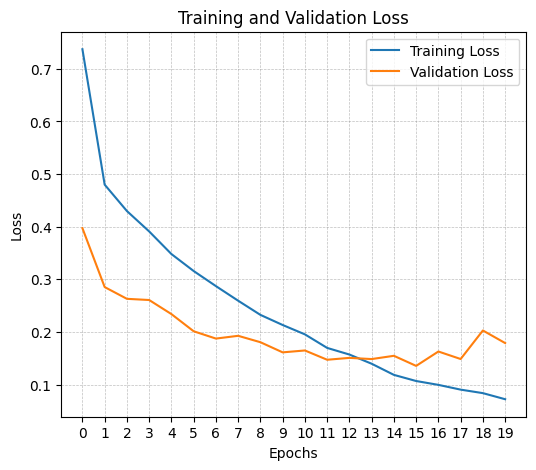

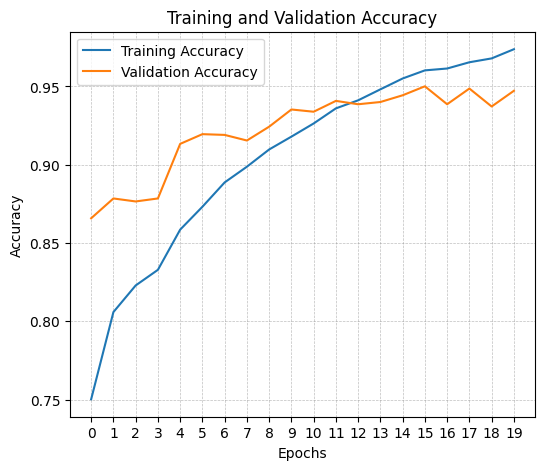

Finished creating Training_Validation_Loss.png and Training_Validation_Accuracy.png
Finished creating Confusion_Matrix
Finished creating ROC_Curve
Finished creating Precision-Recall_Curve


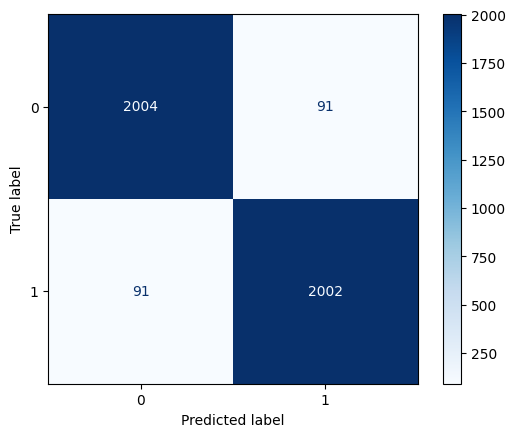

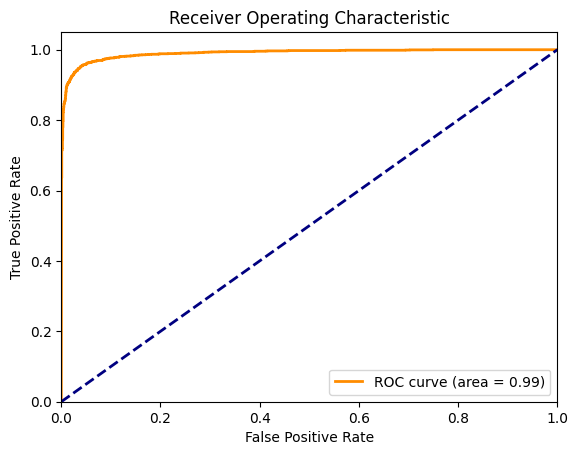

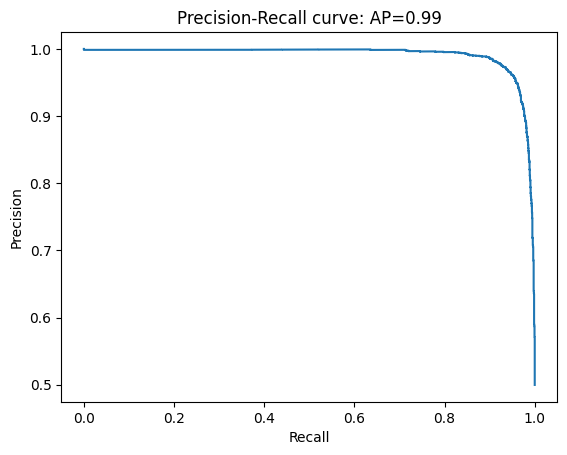

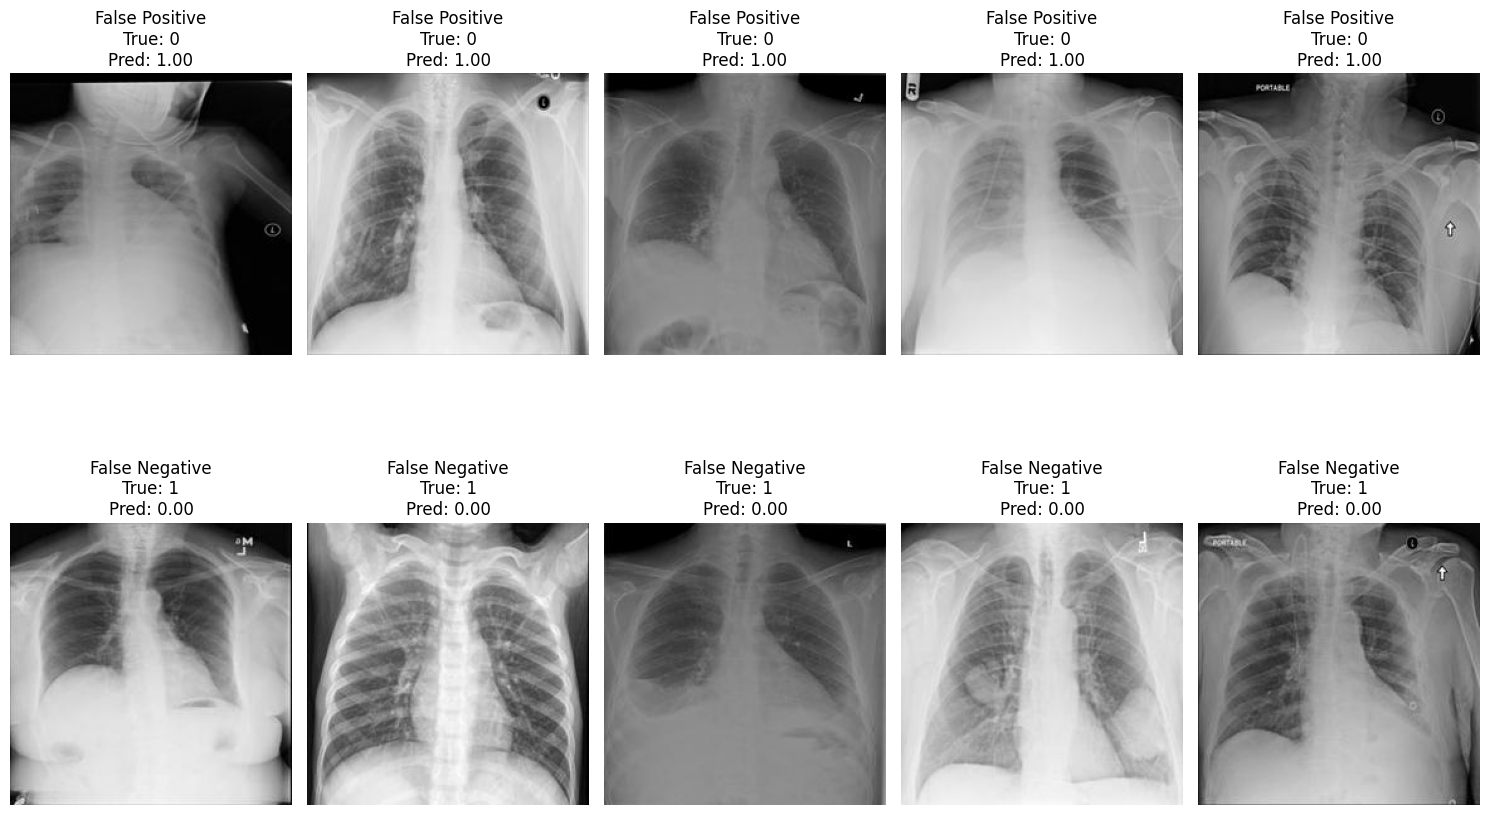

In [1]:
import os
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, Precision, Recall
from IPython.display import Image, display
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score)

from tensorflow.keras.layers import (Input, Conv2D, SeparableConv2D, MaxPooling2D,
                                     BatchNormalization, Flatten, Dense, Dropout)





# Set your batch size and number of epochs
batch_size = 16
nb_epochs = 20

#Win 10
train_path = 'MERGED_ALL_CLEAN_balanced_ready/train'
val_path = 'MERGED_ALL_CLEAN_balanced_ready/val'
test_path = 'MERGED_ALL_CLEAN_balanced_ready/test'


# Initialize ImageDataGenerator without any augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Create the train, validation, and test data generators
train_data_gen = datagen.flow_from_directory(
    directory=train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'  ######### Changed to 'binary' for 2 classes #########
)

valid_data_gen = datagen.flow_from_directory(
    directory=val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary' ######### Changed to 'binary' for 2 classes #########
)

test_data_gen = datagen.flow_from_directory(
    directory=test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',  ######### Changed to 'binary' for 2 classes #########
    shuffle=False
)


def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(256, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x) ######### Changed to 1 unit with 'sigmoid' activation for 2 classes #########
    
    model = Model(inputs=input_img, outputs=x)
    return model

custom_model =  build_model()
#custom_model.summary()


#custom_model.summary()  

# Define optimizer, early stopping, and checkpoint
opt = Adam(learning_rate=0.0001)
es = EarlyStopping(patience=2, restore_best_weights=True)
chkpt = ModelCheckpoint(filepath='best_model_todate.weights.h5', save_best_only=True, save_weights_only=True, save_freq='epoch')

######### Add additional metrics #########



custom_model.compile(
    loss='binary_crossentropy',  ######### Changed to 'binary_crossentropy' for 2 classes #########
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')], 
    optimizer=opt
)


'''
# Train the model
history = custom_model.fit(
    train_data_gen,
    validation_data=valid_data_gen,
    epochs=nb_epochs,
    callbacks=[es, chkpt]
)

history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)

'''

# Load pre-trained weights
custom_model.load_weights('best_model_todate_aug_2000.weights.h5')

#Preparation for plots metrics and gradcam

print("Preparing data structures necessary for plots, metrics, gradcam")

print("Preparing classes from test data generator")
test_classes = test_data_gen.classes
print("Preparing predictions for test data")
y_pred = custom_model.predict(test_data_gen)
print("Flattening predictions")
y_pred_ravel = y_pred.ravel()

####################################################################################################################

# Evaluate the model on the test data
test_loss, test_acc, test_auc, test_precision, test_recall = custom_model.evaluate(test_data_gen)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

####################################################################################################################

val_loss, val_acc, val_auc, val_precision, val_recall = custom_model.evaluate(valid_data_gen)

print(f"Val Accuracy: {val_acc:.4f}")
print(f"Val Loss: {val_loss:.4f}")
print(f"Val AUC: {val_auc:.4f}")
print(f"Val Precision: {val_precision:.4f}")
print(f"Val Recall: {val_recall:.4f}")


with open('training_history_2k.json', 'r') as f:
    history_dict = json.load(f)


####################################################################################################################

# Choose ticks every few epochs
tick_positions = np.arange(0, len(history_dict['loss']), step=1)  # Adjust the step as needed

# Plotting Loss
plt.figure(figsize=(6, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(ticks=tick_positions)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)  # Add barely visible gray grid
plt.savefig('Training_Validation_Loss_aug.png', bbox_inches='tight')
plt.show()
plt.close()

# Plotting Accuracy
plt.figure(figsize=(6, 5))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(ticks=tick_positions)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)  # Add barely visible gray grid
plt.savefig('Training_Validation_Accuracy_aug.png', bbox_inches='tight')
plt.show()
plt.close()

print("Finished creating Training_Validation_Loss.png and Training_Validation_Accuracy.png")

####################################################################################################################


# Generate predictions
y_pred = (y_pred_ravel > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_classes, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('Confusion_Matrix_aug.png', bbox_inches='tight')
print("Finished creating Confusion_Matrix")

####################################################################################################################


#y_pred_prob = custom_model.predict(test_data_gen).ravel()

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(test_classes, y_pred_ravel)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_aug.png', bbox_inches='tight')

print("Finished creating ROC_Curve")

# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=The%20area%20under%20the%20ROC,curve%20(AUC)%20of%201.0.

####################################################################################################################


precision, recall, _ = precision_recall_curve(test_classes, y_pred_ravel)
average_precision = average_precision_score(test_classes, y_pred_ravel)

# Plot Precision-Recall curve
plt.figure()
plt.step(recall, precision, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.savefig('Precision-Recall_Curve_aug.png', bbox_inches='tight')
print("Finished creating Precision-Recall_Curve")

#################################################################################################################### MISSCLASIFIED PICS


def collect_all_predictions(test_data_gen, model):
    # Ensure the generator is set to shuffle=False to get predictions in order
    test_data_gen.shuffle = False
    
    # Pre-allocate arrays for better memory efficiency
    num_samples = test_data_gen.samples
    num_classes = model.output_shape[-1]
    
    all_preds = np.zeros((num_samples, num_classes), dtype=np.float32)
    all_labels = np.zeros((num_samples,) + test_data_gen.labels.shape[1:], dtype=np.float32)
    all_images = np.zeros((num_samples,) + test_data_gen.image_shape, dtype=np.float32)
    
    # Use model.predict on the entire dataset at once
    #all_preds = model.predict(test_data_gen, steps=np.ceil(num_samples/test_data_gen.batch_size).astype(int), verbose=0)
    all_preds = y_pred
    
    # Collect labels and images
    i = 0
    for batch_images, batch_labels in test_data_gen:
        batch_size = batch_images.shape[0]
        if i + batch_size > num_samples:
            batch_size = num_samples - i
        all_labels[i:i+batch_size] = batch_labels[:batch_size]
        all_images[i:i+batch_size] = batch_images[:batch_size]
        i += batch_size
        if i >= num_samples:
            break
    
    return all_preds, all_labels, all_images

def plot_misclassified_images(test_data_gen, model, num_images_per_type=5):
    y_pred, y_true, all_images = collect_all_predictions(test_data_gen, model)
    y_pred_ravel = y_pred.ravel()
    y_pred_class = (y_pred_ravel > 0.5).astype(int)
    
    false_positives_indices = np.where((y_pred_class == 1) & (y_true == 0))[0]
    false_negatives_indices = np.where((y_pred_class == 0) & (y_true == 1))[0]
    
    num_false_positives = min(num_images_per_type, len(false_positives_indices))
    num_false_negatives = min(num_images_per_type, len(false_negatives_indices))
    
    random_false_positives = np.random.choice(false_positives_indices, num_false_positives, replace=False)
    random_false_negatives = np.random.choice(false_negatives_indices, num_false_negatives, replace=False)
    
    fig, axes = plt.subplots(2, num_images_per_type, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, idx in enumerate(random_false_positives):
        img = (all_images[idx] * 255.0).astype(np.uint8)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'False Positive\nTrue: {y_true[idx]:.0f}\nPred: {y_pred_ravel[idx]:.2f}')
    
    for i, idx in enumerate(random_false_negatives):
        img = (all_images[idx] * 255.0).astype(np.uint8)
        axes[num_images_per_type + i].imshow(img)
        axes[num_images_per_type + i].axis('off')
        axes[num_images_per_type + i].set_title(f'False Negative\nTrue: {y_true[idx]:.0f}\nPred: {y_pred_ravel[idx]:.2f}')
    
    plt.tight_layout()
    plt.savefig('Missclassified_images_aug.png', bbox_inches='tight')
    plt.show()
    
# Plot misclassified images
plot_misclassified_images(test_data_gen, custom_model)

####################################################################################################################



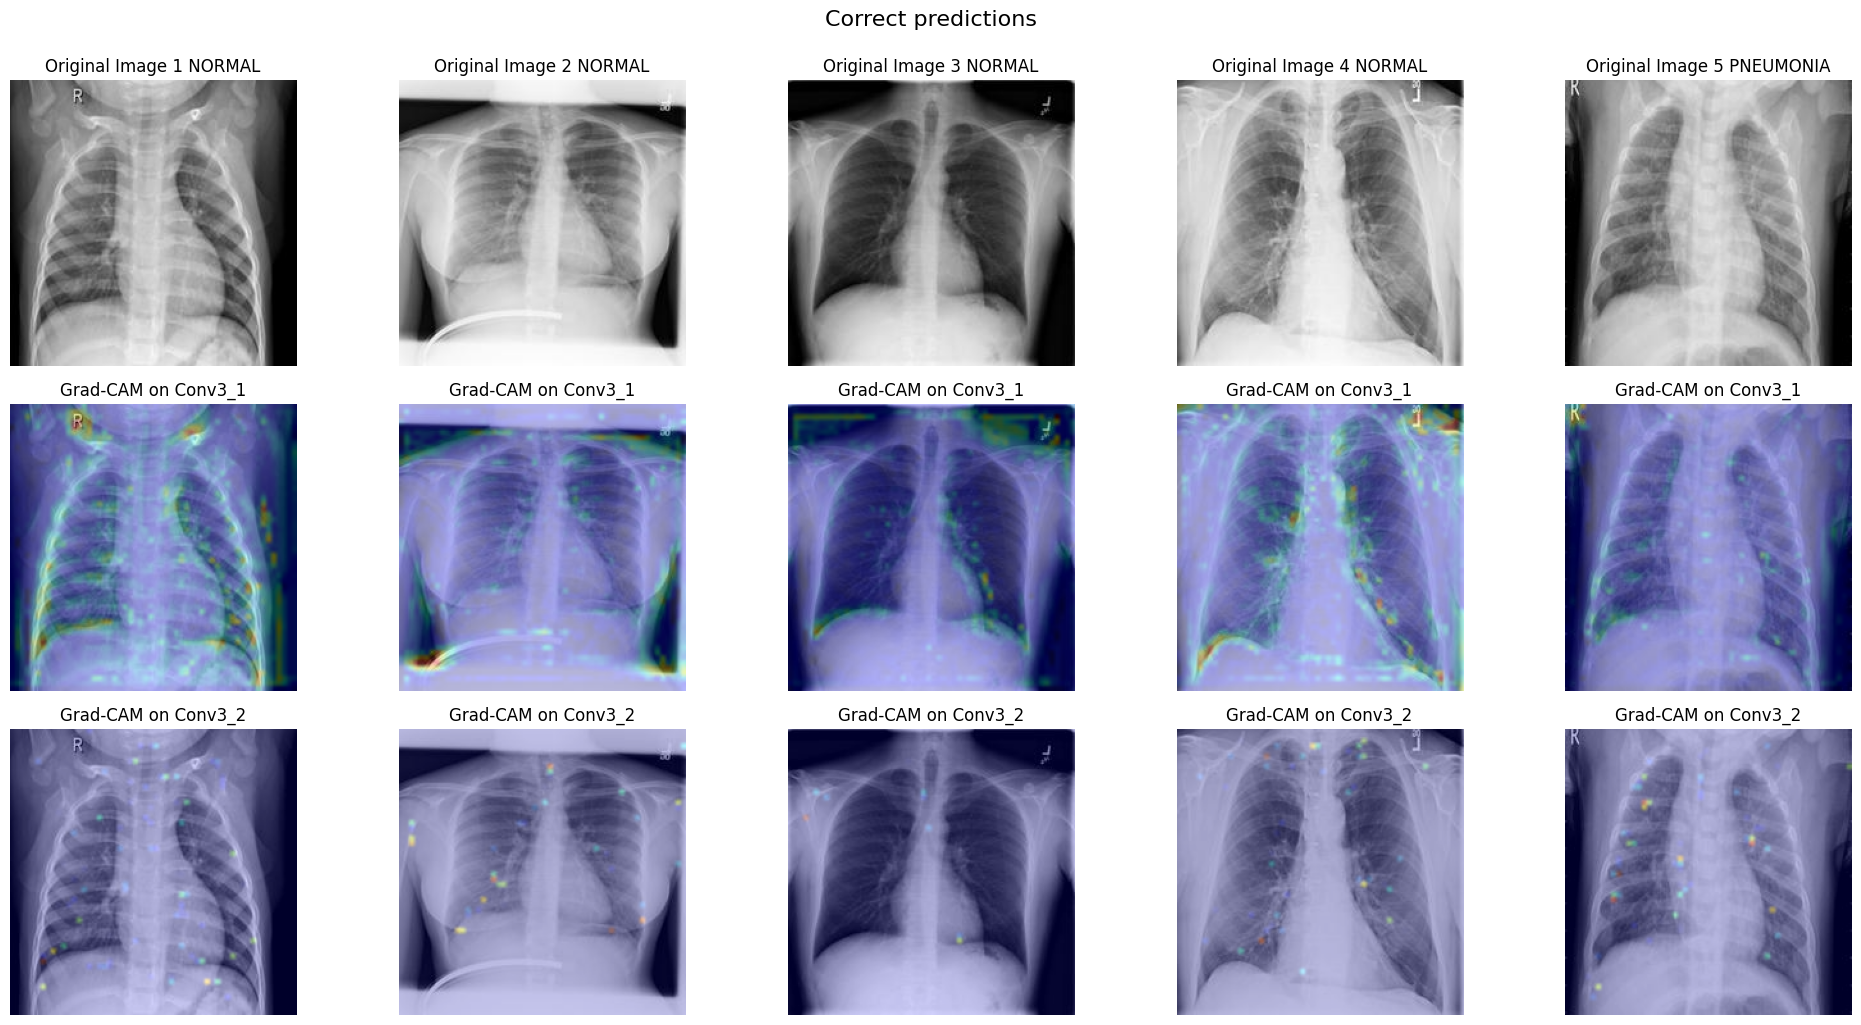

In [8]:
from tensorflow.keras.applications.vgg19 import preprocess_input
custom_model.layers[-1].activation = None
def display_multiple_gradcam(model, data_gen, class_names, conv_layers, img_size=(224, 224), precomputed_predictions=None):
    """
    Displays Grad-CAM heatmaps for 5 different correctly predicted images, for two specified convolutional layers.

    Parameters:
    model (keras.Model): The trained model used for prediction.
    data_gen (keras.preprocessing.image.DirectoryIterator): The data generator for the test dataset.
    class_names (list): A list containing the class names, e.g., ['PNEUMONIA', 'NORMAL'].
    conv_layers (list): A list of convolutional layer names for Grad-CAM, e.g., ['conv3_2', 'conv3_1'].
    img_size (tuple): The target size for image processing (width, height).
    precomputed_predictions (numpy.ndarray): Precomputed binary predictions that are already flattened and rounded.
    """
    
    def get_correct_prediction_paths(model, data_gen, class_names, num_images=5, precomputed_predictions=None):
        """
        Returns a list of paths to images that were correctly predicted by the model.

        Parameters:
        model (keras.Model): The trained model used for prediction.
        data_gen (keras.preprocessing.image.DirectoryIterator): The data generator for the test dataset.
        class_names (list): A list containing the class names, e.g., ['PNEUMONIA', 'NORMAL'].
        num_images (int): The number of correctly predicted images to retrieve.
        precomputed_predictions (numpy.ndarray): Precomputed binary predictions that are already flattened.

        Returns:
        list: A list of file paths to correctly predicted images.
        """
        if precomputed_predictions is not None:
            # Use the provided precomputed predictions
            predicted_labels = np.round(precomputed_predictions)
        else:
            # Get predictions for the entire test set
            predictions = model.predict(data_gen, verbose=1)
            
            # Convert predictions to binary labels (0 or 1)
            predicted_labels = np.round(predictions).flatten()

        # Get the true labels from the data generator
        true_labels = data_gen.labels

        # Get the file paths for all images in the test set
        file_paths = data_gen.filepaths

        # Get the class indices for the specified classes
        class_indices = {name: data_gen.class_indices[name] for name in class_names}

        # Find correctly predicted images for the specified classes
        correctly_predicted_paths = [
            file_paths[i] for i in range(len(true_labels))
            if any(predicted_labels[i] == true_labels[i] == class_indices[class_name] for class_name in class_names)
        ]

        # If there are correctly predicted images, choose a random set of them
        if len(correctly_predicted_paths) >= num_images:
            return random.sample(correctly_predicted_paths, num_images)
        else:
            return correctly_predicted_paths

    def get_img_array(img_path, size):
        """Converts an image to a numpy array."""
        img = keras.utils.load_img(img_path, target_size=size)
        array = keras.utils.img_to_array(img)
        array = np.expand_dims(array, axis=0)
        return array

    def make_gradcam_heatmap(img_array, model, conv_layer_name, pred_index=None):
        """Generates a Grad-CAM heatmap."""
        grad_model = keras.models.Model(
            model.inputs, [model.get_layer(conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_layer_output, preds = grad_model(img_array, training=False)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_layer_output = conv_layer_output[0]
        heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def save_and_display_gradcam(img, heatmap, alpha=0.4):
        """Generates the Grad-CAM image and returns it as a numpy array."""
        heatmap = np.uint8(255 * heatmap)
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.utils.array_to_img(superimposed_img)
        return np.array(superimposed_img)

    # Get paths to 5 correctly predicted images
    img_paths = get_correct_prediction_paths(
        model=model, 
        data_gen=data_gen, 
        class_names=class_names,
        num_images=5,
        precomputed_predictions=precomputed_predictions  # Pass this if it exists, or pass None
    )

    if not img_paths:
        print("No correctly predicted images found.")
        return

    # Create subplots
    num_images = len(img_paths)
    num_layers = len(conv_layers)
    fig, axs = plt.subplots(num_layers + 1, num_images, figsize=(20, 10))
    
    # Add a suptitle to the entire figure
    fig.suptitle("Correct predictions", fontsize=16, y=1.02)
    
    for i, img_path in enumerate(img_paths):
        # Display the original image in the first row
        img = keras.utils.load_img(img_path)
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        
        # Extract just the NORMAL or PNEUMONIA part from the filename
        filename = os.path.basename(img_path)
        category = filename.split()[0]  # This will be either NORMAL or PNEUMONIA
        
        axs[0, i].imshow(img)
        axs[0, i].set_title(f"Original Image {i+1} {category}")
        axs[0, i].axis('off')
        
        for j, layer in enumerate(conv_layers):
            # Generate and display the Grad-CAM heatmap for each specified layer
            heatmap = make_gradcam_heatmap(img_array, model, layer)
            gradcam_img = save_and_display_gradcam(keras.utils.img_to_array(img), heatmap)
            
            axs[j + 1, i].imshow(gradcam_img)
            axs[j + 1, i].set_title(f"Grad-CAM on {layer}")
            axs[j + 1, i].axis('off')
    
    plt.tight_layout()
    # Adjust the layout to make room for the suptitle
    plt.subplots_adjust(top=0.95)
    plt.savefig('Gradcam_correct_aug.png', bbox_inches='tight')
    plt.show()

display_multiple_gradcam(custom_model, test_data_gen, ['PNEUMONIA', 'NORMAL'], ['Conv3_1', 'Conv3_2'], precomputed_predictions=y_pred_ravel)

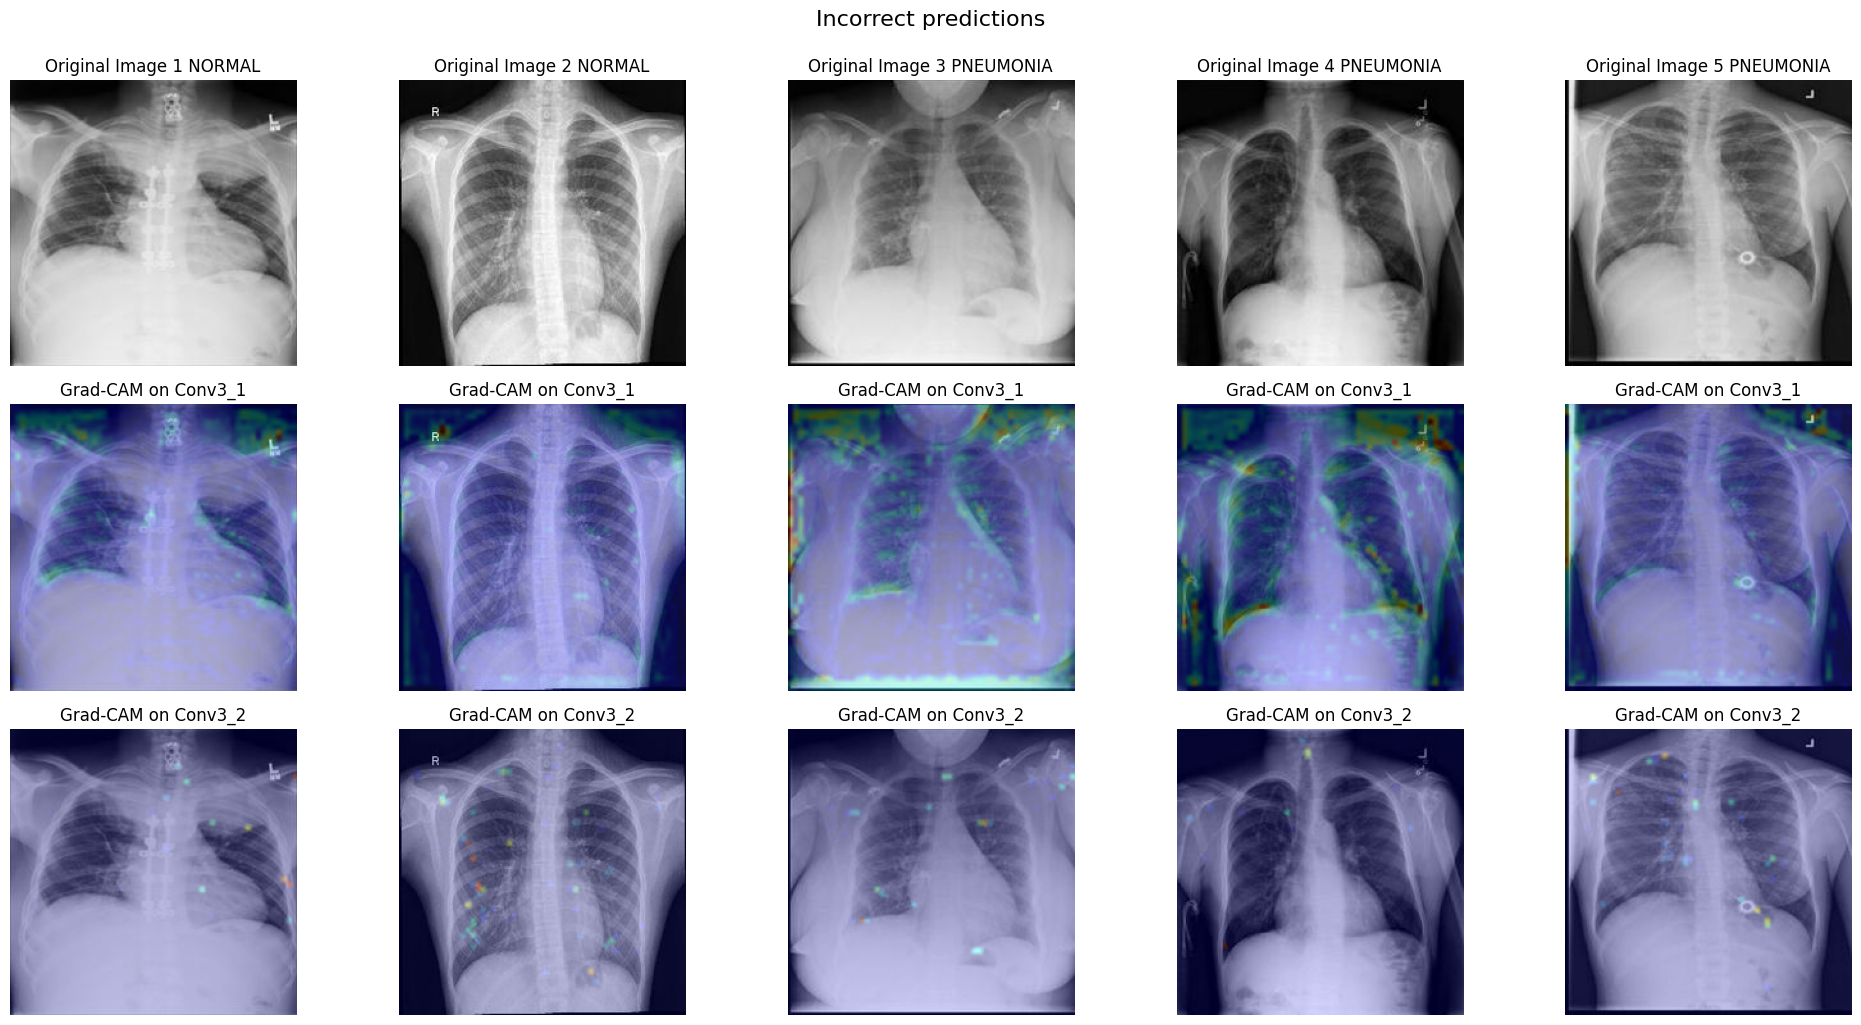

In [9]:
def display_multiple_gradcam(model, data_gen, class_names, conv_layers, img_size=(224, 224), precomputed_predictions=None):
    """
    Displays Grad-CAM heatmaps for 5 different incorrectly predicted images, for two specified convolutional layers.

    Parameters:
    model (keras.Model): The trained model used for prediction.
    data_gen (keras.preprocessing.image.DirectoryIterator): The data generator for the test dataset.
    class_names (list): A list containing the class names, e.g., ['PNEUMONIA', 'NORMAL'].
    conv_layers (list): A list of convolutional layer names for Grad-CAM, e.g., ['conv3_2', 'conv3_1'].
    img_size (tuple): The target size for image processing (width, height).
    precomputed_predictions (numpy.ndarray): Precomputed binary predictions that are already flattened and rounded.
    """

    def get_random_incorrect_prediction_path(model, data_gen, class_names, precomputed_predictions=None):
        """
        Returns a random path of an image that was incorrectly predicted by the model.

        Parameters:
        model (keras.Model): The trained model used for prediction.
        data_gen (keras.preprocessing.image.DirectoryIterator): The data generator for the test dataset.
        class_names (list): A list containing the class names, e.g., ['PNEUMONIA', 'NORMAL'].
        precomputed_predictions (numpy.ndarray): Precomputed binary predictions that are already flattened.

        Returns:
        str: The file path of an incorrectly predicted image, or None if no incorrectly predicted images are found.
        """
        if precomputed_predictions is not None:
            # Use the provided precomputed predictions
            predicted_labels = np.round(precomputed_predictions)
        else:
            # Get predictions for the entire test set
            predictions = model.predict(data_gen, verbose=1)
            
            # Convert predictions to binary labels (0 or 1)
            predicted_labels = np.round(predictions).flatten()

        # Get the true labels from the data generator
        true_labels = data_gen.labels

        # Get the file paths for all images in the test set
        file_paths = data_gen.filepaths

        # Find incorrectly predicted images for the specified classes
        incorrectly_predicted_paths = [
            file_paths[i] for i in range(len(true_labels))
            if predicted_labels[i] != true_labels[i]  # Check for incorrect predictions
        ]

        # If there are incorrectly predicted images, choose a random one
        if incorrectly_predicted_paths:
            return random.choice(incorrectly_predicted_paths)
        else:
            return None

    def get_img_array(img_path, size):
        """Converts an image to a numpy array."""
        img = keras.utils.load_img(img_path, target_size=size)
        array = keras.utils.img_to_array(img)
        array = np.expand_dims(array, axis=0)
        return array

    def make_gradcam_heatmap(img_array, model, conv_layer_name, pred_index=None):
        """Generates a Grad-CAM heatmap."""
        grad_model = keras.models.Model(
            model.inputs, [model.get_layer(conv_layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            conv_layer_output, preds = grad_model(img_array, training=False)
            if pred_index is None:
                pred_index = tf.argmax(preds[0])
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_layer_output = conv_layer_output[0]
        heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
        heatmap = tf.squeeze(heatmap)
        heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
        return heatmap.numpy()

    def save_and_display_gradcam(img, heatmap, alpha=0.4):
        """Generates the Grad-CAM image and returns it as a numpy array."""
        heatmap = np.uint8(255 * heatmap)
        jet = mpl.colormaps["jet"]
        jet_colors = jet(np.arange(256))[:, :3]
        jet_heatmap = jet_colors[heatmap]
        jet_heatmap = keras.utils.array_to_img(jet_heatmap)
        jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
        jet_heatmap = keras.utils.img_to_array(jet_heatmap)

        superimposed_img = jet_heatmap * alpha + img
        superimposed_img = keras.utils.array_to_img(superimposed_img)
        return np.array(superimposed_img)

    # Get paths to 5 incorrectly predicted images
    img_paths = [
        get_random_incorrect_prediction_path(
            model=model, 
            data_gen=data_gen, 
            class_names=class_names,
            precomputed_predictions=precomputed_predictions
        )
        for _ in range(5)
    ]

    # Filter out any None values in case fewer than 5 incorrect predictions are found
    #print(img_paths)
    img_paths = [path for path in img_paths if path is not None]

    if not img_paths:
        print("No incorrectly predicted images found.")
        return

    # Create subplots
    num_images = len(img_paths)
    num_layers = len(conv_layers)
    fig, axs = plt.subplots(num_layers + 1, num_images, figsize=(20, 10))
    
    # Add a suptitle to the entire figure
    fig.suptitle("Incorrect predictions", fontsize=16, y=1.02)
    
    for i, img_path in enumerate(img_paths):
        # Display the original image in the first row
        img = keras.utils.load_img(img_path)
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        
        # Extract just the NORMAL or PNEUMONIA part from the filename
        filename = os.path.basename(img_path)
        category = filename.split()[0]  # This will be either NORMAL or PNEUMONIA
        
        axs[0, i].imshow(img)
        axs[0, i].set_title(f"Original Image {i+1} {category}")
        axs[0, i].axis('off')
        
        for j, layer in enumerate(conv_layers):
            # Generate and display the Grad-CAM heatmap for each specified layer
            heatmap = make_gradcam_heatmap(img_array, model, layer)
            gradcam_img = save_and_display_gradcam(keras.utils.img_to_array(img), heatmap)
            
            axs[j + 1, i].imshow(gradcam_img)
            axs[j + 1, i].set_title(f"Grad-CAM on {layer}")
            axs[j + 1, i].axis('off')
    
    plt.tight_layout()
    # Adjust the layout to make room for the suptitle
    plt.subplots_adjust(top=0.95)
    plt.savefig('Gradcam_incorrect_aug.png', bbox_inches='tight')
    plt.show()
display_multiple_gradcam(custom_model, test_data_gen, ['PNEUMONIA', 'NORMAL'], ['Conv3_1', 'Conv3_2'], precomputed_predictions=y_pred_ravel)